## Get Data

In [1]:
import pandas as pd

In [2]:
train_df = pd.read_csv('../input/train_set.csv')
val_df = pd.read_csv ('../input/val_set.csv')
test_df = pd.read_csv('../input/test_set.csv')

In [3]:
print(f'Train Set Shape: {train_df.shape}')
print(f'Validation Set Shape: {val_df.shape}')
print(f'Test Set Shape: {test_df.shape}')

Train Set Shape: (6000, 7)
Validation Set Shape: (1000, 7)
Test Set Shape: (1000, 7)


## Prepare Data

### Train a FastText Model on Data

In [4]:
from gensim.models import FastText

In [5]:
# Size of pretrained embedding
embedding_size = 100

# Word Limit for each input document
max_words = 100

In [6]:
train_sentences = train_df['News Text'].apply(lambda x: x.split()).to_list()

In [7]:
fasttext_model = FastText(sentences=train_sentences, vector_size=embedding_size, window=5, min_count=1, workers=4)

### Representing Each Article as a Vector

In [8]:
import numpy as np

In [9]:
def get_embedding(word):
    try:
        return fasttext_model.wv[word]
    except KeyError:  
        return np.zeros(embedding_size)

def get_article_tensor(article):
    words = article.split()
    word_embeddings = [get_embedding(word) for word in words[:max_words]] 
    
    if len(word_embeddings) < max_words:  # Pad if needed
        word_embeddings += [np.zeros(embedding_size)] * (max_words - len(word_embeddings))
    return np.array(word_embeddings)

In [10]:
# Get Feature Matrix
train_x = np.array([get_article_tensor(article) for article in train_df['News Text']])

val_x = np.array([get_article_tensor(article) for article in val_df['News Text']])

test_x = np.array([get_article_tensor(article) for article in test_df['News Text']])

In [11]:
print(f'Train Features: {train_x.shape}')
print(f'Validation Features Shape: {val_x.shape}')
print(f'Test Features Shape: {test_x.shape}')

Train Features: (6000, 100, 100)
Validation Features Shape: (1000, 100, 100)
Test Features Shape: (1000, 100, 100)


### Get Label Data

In [12]:
from sklearn.preprocessing import LabelEncoder

In [13]:
encoder = LabelEncoder()
train_y = encoder.fit_transform(train_df["Category"])
val_y = encoder.transform (val_df["Category"])
test_y = encoder.transform (test_df["Category"])

In [14]:
print(f'train_y shape: {train_y.shape}')
print(f'test_y shape: {val_y.shape}')
print(f'test_y shape: {test_y.shape}')

train_y shape: (6000,)
test_y shape: (1000,)
test_y shape: (1000,)


# Model Training

In [17]:
from keras.models import Sequential
from keras.layers import Input, Dense, LSTM, Bidirectional

### Function to Plot Losses

In [16]:
import matplotlib.pyplot as plt

def plot_losses(history):
    
    train_loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    
    epochs = range(len(train_loss))
    
    # Plot
    plt.plot(epochs, train_loss, label="Training Loss", color="blue")
    plt.plot(epochs, val_loss, label="Validation Loss", color="red")

    # Labels and legend
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.show()

### Early Stopping Callback

In [18]:
from keras.callbacks import EarlyStopping

# Early stopping
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5,
    restore_best_weights=True
)

## Model 1

In [23]:
# create model
model_1 = Sequential()
model_1.add(Input(shape=(max_words, embedding_size)))
model_1.add(Bidirectional(LSTM(4)))
model_1.add(Dense(4, activation='sigmoid'))
model_1.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [24]:
history_1 = model_1.fit(train_x, train_y, epochs=20, batch_size=8, validation_data=(val_x, val_y), callbacks=early_stopping)

Epoch 1/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - acc: 0.7526 - loss: 0.7294 - val_acc: 0.9060 - val_loss: 0.3173
Epoch 2/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - acc: 0.9110 - loss: 0.2904 - val_acc: 0.9090 - val_loss: 0.3106
Epoch 3/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - acc: 0.9220 - loss: 0.2549 - val_acc: 0.9250 - val_loss: 0.2835
Epoch 4/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - acc: 0.9227 - loss: 0.2660 - val_acc: 0.9330 - val_loss: 0.2676
Epoch 5/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - acc: 0.9318 - loss: 0.2232 - val_acc: 0.9280 - val_loss: 0.2538
Epoch 6/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - acc: 0.9423 - loss: 0.2051 - val_acc: 0.9290 - val_loss: 0.2552
Epoch 7/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - acc: 0.9377 - loss: 0.2115 - val_acc: 0.9260 - val_loss: 0.2409
Epoch 8/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - acc: 0.9433 - loss: 0.1931 - val_acc: 0.9250 - val_loss: 0.2590
Epoch 9/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 

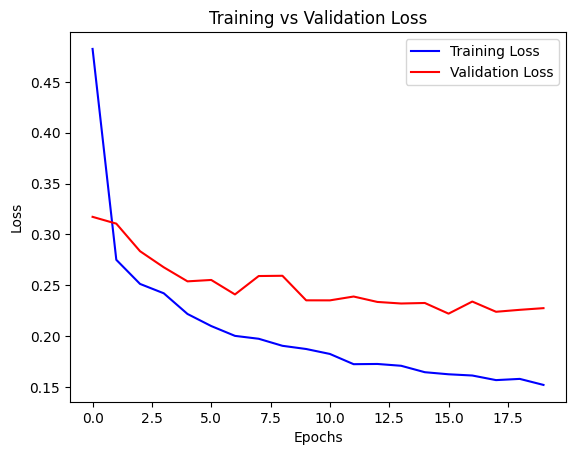

In [25]:
plot_losses(history_1)

### Conclusion: Steady Decrease of Validation loss for 20 epochs

## Model 2

### Increase epochs

In [28]:
# create model
model_2 = Sequential()
model_2.add(Input(shape=(max_words, embedding_size)))
model_2.add(Bidirectional(LSTM(4)))
model_2.add(Dense(4, activation='sigmoid'))
model_2.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [29]:
history_2 = model_2.fit(train_x, train_y, epochs=30, batch_size=8, validation_data=(val_x, val_y), callbacks=early_stopping)

Epoch 1/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - acc: 0.7688 - loss: 0.7038 - val_acc: 0.9110 - val_loss: 0.3178
Epoch 2/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - acc: 0.9098 - loss: 0.3044 - val_acc: 0.9060 - val_loss: 0.3044
Epoch 3/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - acc: 0.9189 - loss: 0.2609 - val_acc: 0.9180 - val_loss: 0.2990
Epoch 4/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - acc: 0.9333 - loss: 0.2205 - val_acc: 0.9160 - val_loss: 0.2805
Epoch 5/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - acc: 0.9304 - loss: 0.2280 - val_acc: 0.9120 - val_loss: 0.2864
Epoch 6/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - acc: 0.9401 - loss: 0.2108 - val_acc: 0.9220 - val_loss: 0.2623
Epoch 7/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - acc: 0.9359 - loss: 0.2059 - val_acc: 0.9210 - val_loss: 0.2592
Epoch 8/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - acc: 0.9440 - loss: 0.1999 - val_acc: 0.9210 - val_loss: 0.2567
Epoch 9/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 

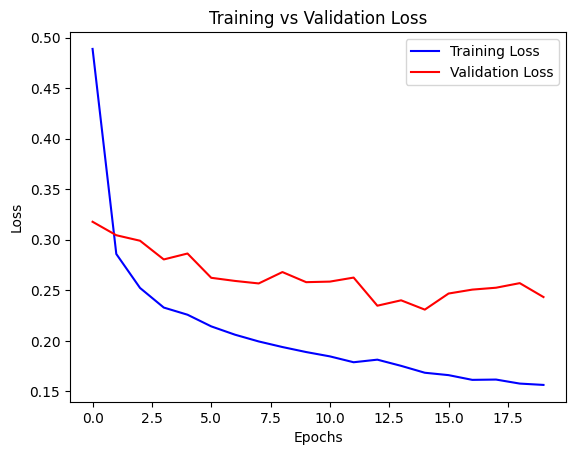

In [30]:
plot_losses(history_2)

### Conclusion: Best model reached within 20 epochs

## Model 3

### Increase Nodes

In [31]:
# create model
model_3 = Sequential()
model_3.add(Input(shape=(max_words, embedding_size)))
model_3.add(Bidirectional(LSTM(8)))
model_3.add(Dense(4, activation='sigmoid'))
model_3.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [32]:
history_3 = model_3.fit(train_x, train_y, epochs=40, batch_size=8, validation_data=(val_x, val_y), callbacks = early_stopping)

Epoch 1/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - acc: 0.8184 - loss: 0.5568 - val_acc: 0.9140 - val_loss: 0.2864
Epoch 2/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - acc: 0.9357 - loss: 0.2190 - val_acc: 0.9160 - val_loss: 0.2550
Epoch 3/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - acc: 0.9422 - loss: 0.2085 - val_acc: 0.9250 - val_loss: 0.2447
Epoch 4/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - acc: 0.9432 - loss: 0.1882 - val_acc: 0.9400 - val_loss: 0.2373
Epoch 5/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - acc: 0.9420 - loss: 0.1835 - val_acc: 0.9310 - val_loss: 0.2335
Epoch 6/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - acc: 0.9538 - loss: 0.1506 - val_acc: 0.9370 - val_loss: 0.2223
Epoch 7/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - acc: 0.9523 - loss: 0.1638 - val_acc: 0.9410 - val_loss: 0.2278
Epoch 8/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - acc: 0.9528 - loss: 0.1565 - val_acc: 0.9340 - val_loss: 0.2236
Epoch 9/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 

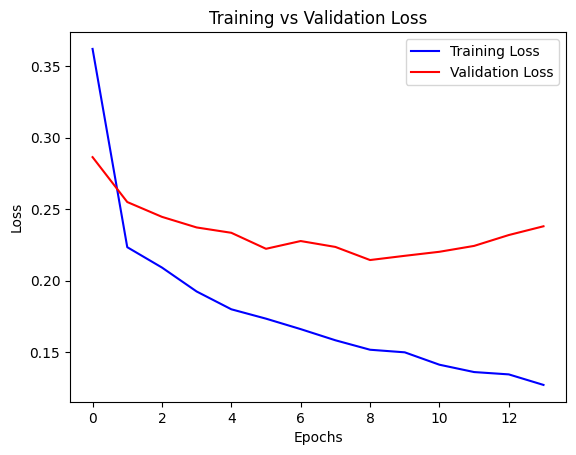

In [33]:
plot_losses(history_3)

### Conclusion: Validation loss reaches lowest value of 0.2145 with a corresponding accuray of 93.7. This is better than the best performing LSTM.

## Model 4

### Increase Nodes to 10

In [34]:
# create model
model_4 = Sequential()
model_4.add(Input(shape=(max_words, embedding_size)))
model_4.add(Bidirectional(LSTM(10)))
model_4.add(Dense(4, activation='sigmoid'))
model_4.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [35]:
history_4 = model_4.fit(train_x, train_y, epochs=20, batch_size=8, validation_data=(val_x, val_y), callbacks=early_stopping)

Epoch 1/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - acc: 0.8166 - loss: 0.5974 - val_acc: 0.9200 - val_loss: 0.2735
Epoch 2/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - acc: 0.9316 - loss: 0.2200 - val_acc: 0.9250 - val_loss: 0.2423
Epoch 3/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - acc: 0.9381 - loss: 0.2048 - val_acc: 0.9280 - val_loss: 0.2399
Epoch 4/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - acc: 0.9461 - loss: 0.1750 - val_acc: 0.9270 - val_loss: 0.2441
Epoch 5/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - acc: 0.9510 - loss: 0.1726 - val_acc: 0.9350 - val_loss: 0.2319
Epoch 6/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - acc: 0.9508 - loss: 0.1629 - val_acc: 0.9340 - val_loss: 0.2373
Epoch 7/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - acc: 0.9576 - loss: 0.1498 - val_acc: 0.9280 - val_loss: 0.2520
Epoch 8/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - acc: 0.9545 - loss: 0.1489 - val_acc: 0.9330 - val_loss: 0.2316
Epoch 9/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 

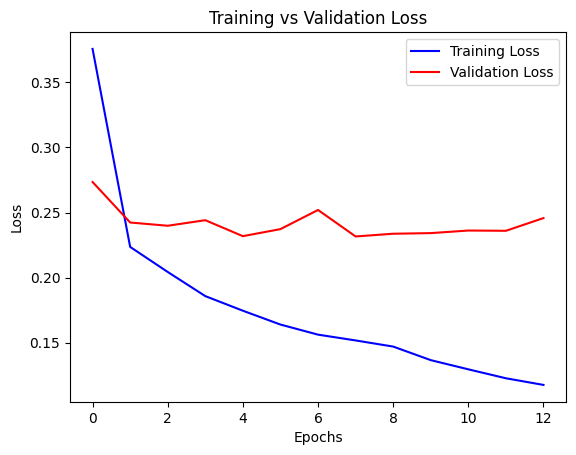

In [36]:
plot_losses(history_4)

### Conclusion: Model performance dips when nodes are increased to 10

## Model 5

### Change Nodes from 8 to 6

In [39]:
# create model
model_5 = Sequential()
model_5.add(Input(shape=(max_words, embedding_size)))
model_5.add(Bidirectional(LSTM(6)))
model_5.add(Dense(4, activation='sigmoid'))
model_5.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [40]:
history_5 = model_5.fit(train_x, train_y, epochs=40, batch_size=8, validation_data=(val_x, val_y), callbacks=early_stopping)

Epoch 1/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - acc: 0.7648 - loss: 0.6964 - val_acc: 0.9050 - val_loss: 0.3233
Epoch 2/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - acc: 0.9147 - loss: 0.2950 - val_acc: 0.9180 - val_loss: 0.3098
Epoch 3/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - acc: 0.9279 - loss: 0.2480 - val_acc: 0.9160 - val_loss: 0.2987
Epoch 4/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - acc: 0.9326 - loss: 0.2315 - val_acc: 0.9240 - val_loss: 0.2591
Epoch 5/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - acc: 0.9378 - loss: 0.2124 - val_acc: 0.9260 - val_loss: 0.2485
Epoch 6/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - acc: 0.9413 - loss: 0.1898 - val_acc: 0.9250 - val_loss: 0.2558
Epoch 7/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - acc: 0.9471 - loss: 0.1758 - val_acc: 0.9360 - val_loss: 0.2221
Epoch 8/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - acc: 0.9487 - loss: 0.1742 - val_acc: 0.9310 - val_loss: 0.2329
Epoch 9/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 

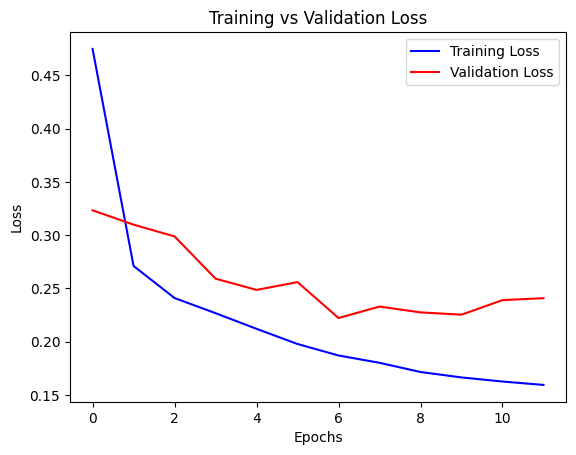

In [41]:
plot_losses(history_5)

### Conclusion: Model with 6 nodes does not improve on model with 8 nodes

## Model 6

### Add Recurrent Dropout

In [53]:
# create model
model_6 = Sequential()
model_6.add(Input(shape=(max_words, embedding_size)))
model_6.add(Bidirectional(LSTM(8, recurrent_dropout=0.2)))
model_6.add(Dense(4, activation='sigmoid'))
model_6.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [54]:
history_6 = model_6.fit(train_x, train_y, epochs=40, batch_size=8, validation_data=(val_x, val_y), callbacks=early_stopping)

Epoch 1/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - acc: 0.7673 - loss: 0.6884 - val_acc: 0.9210 - val_loss: 0.2769
Epoch 2/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - acc: 0.9144 - loss: 0.2760 - val_acc: 0.9130 - val_loss: 0.2658
Epoch 3/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - acc: 0.9283 - loss: 0.2377 - val_acc: 0.9350 - val_loss: 0.2508
Epoch 4/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - acc: 0.9354 - loss: 0.2100 - val_acc: 0.9320 - val_loss: 0.2425
Epoch 5/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - acc: 0.9349 - loss: 0.2162 - val_acc: 0.9350 - val_loss: 0.2298
Epoch 6/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - acc: 0.9459 - loss: 0.1824 - val_acc: 0.9340 - val_loss: 0.2440
Epoch 7/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - acc: 0.9452 - loss: 0.1829 - val_acc: 0.9360 - val_loss: 0.2320
Epoch 8/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - acc: 0.9438 - loss: 0.1820 - val_acc: 0.9460 - val_loss: 0.2131
Epoch 9/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 

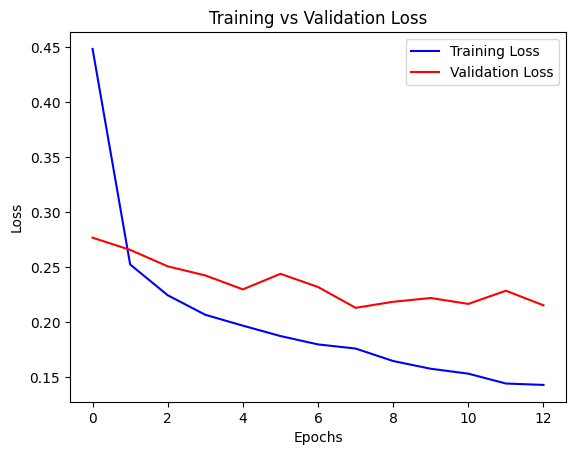

In [55]:
plot_losses(history_6)

### Conclusion: Recurrent dropout improves performance, giving us the lowest validation score so far

## Model 7

### Add Regularization

In [19]:
from keras.regularizers import l2

In [20]:
# create model
model_7 = Sequential()
model_7.add(Input(shape=(max_words, embedding_size)))
model_7.add(Bidirectional(LSTM(8, recurrent_dropout=0.2, kernel_regularizer=l2(0.001))))
model_7.add(Dense(4, activation='sigmoid'))
model_7.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

2025-03-21 21:41:47.787374: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [21]:
history_7 = model_7.fit(train_x, train_y, epochs=40, batch_size=8, validation_data=(val_x, val_y), callbacks=early_stopping)

Epoch 1/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - acc: 0.8139 - loss: 0.7124 - val_acc: 0.9070 - val_loss: 0.3635
Epoch 2/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - acc: 0.9260 - loss: 0.3035 - val_acc: 0.9200 - val_loss: 0.3297
Epoch 3/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - acc: 0.9359 - loss: 0.2560 - val_acc: 0.9370 - val_loss: 0.2766
Epoch 4/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - acc: 0.9414 - loss: 0.2453 - val_acc: 0.9390 - val_loss: 0.2609
Epoch 5/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - acc: 0.9477 - loss: 0.2160 - val_acc: 0.9330 - val_loss: 0.2594
Epoch 6/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - acc: 0.9395 - loss: 0.2254 - val_acc: 0.9310 - val_loss: 0.2585
Epoch 7/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - acc: 0.9485 - loss: 0.2051 - val_acc: 0.9370 - val_loss: 0.2435
Epoch 8/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - acc: 0.9463 - loss: 0.2017 - val_acc: 0.9420 - val_loss: 0.2226
Epoch 9/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 

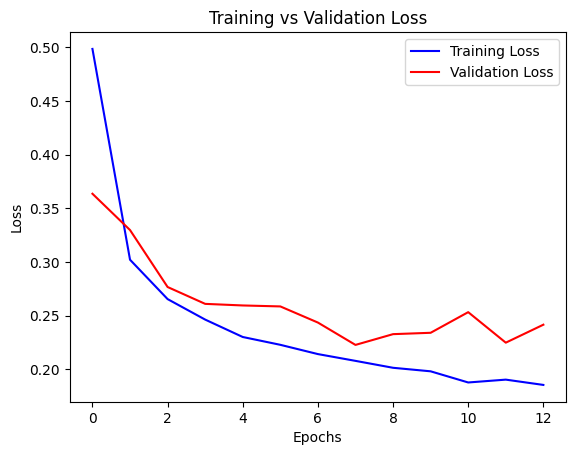

In [22]:
plot_losses(history_7)

### Conclusion: Reglarisation (even with a small value of 0.001) increases both validation loss (0.2131 to 0.2413) and decreases accuracy (0.946 to 0.938), a visible loss of the model's learning capability.

# Get Metrics on Test Set

In [23]:
from sklearn.metrics import classification_report, accuracy_score

In [68]:
y_pred = model_6.predict(test_x)

# Get Label with highest probability
y_pred = y_pred.argmax(axis=1)  

# Generate classification report
report = classification_report(test_y, y_pred, digits=4)  
accuracy = accuracy_score(test_y, y_pred)  

print(report)
print(f"Accuracy: {accuracy:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
              precision    recall  f1-score   support

           0     0.9360    0.9360    0.9360       250
           1     0.9342    0.9080    0.9209       250
           2     0.9222    0.9480    0.9349       250
           3     0.9600    0.9600    0.9600       250

    accuracy                         0.9380      1000
   macro avg     0.9381    0.9380    0.9380      1000
weighted avg     0.9381    0.9380    0.9380      1000

Accuracy: 0.9380
